# Neural Network from scratch

In this notebook we will learn how to build a neural network from scratch, implementing the forward and the backward propagation and training it on the MNIST dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


# Preprocessing
We will cover this dataset further in future practises, but let's take a look at it:

<Figure size 432x288 with 0 Axes>

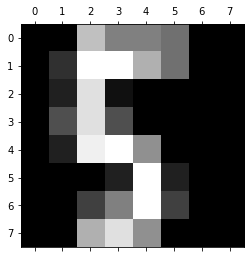

In [7]:
%matplotlib inline
dig = load_digits()
plt.gray()
plt.matshow(dig.images[25])

Simple train/test split with one hot features on the target

In [11]:
onehot_target = pd.get_dummies(dig.target)
x_train, x_val, y_train, y_val = train_test_split(dig.data, onehot_target, test_size=0.1, random_state=20)
onehot_target.head()

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0


## Architechture and basic operations
We willl cover the base of the network, which will be a [128, 128, 10] fully connected network, including all the weights for each layer and its biases.

**Finish implementing the basic architechture**

*Weight matrixes can be initialized with rnp.random.randn, while biases could be initialised with zeros (np.zeros). Keep in mind dimensions*

In [12]:
import numpy as np
class MyNN:
    def __init__(self, x, y):
        self.input = x
        self.target = np.array(y)
        neurons = 128       # neurons for hidden layers
        self.lr = 0.5       # user defined learning rate
        ip_dim = x.shape[1] # input layer size
        op_dim = y.shape[1] # output layer size 
        self.w1 = np.random.randn(ip_dim, neurons) # weights
        self.b1 = np.zeros((1, neurons))           # biases
        self.w2 = np.random.randn(neurons, neurons)
        self.b2 = np.zeros((1, neurons))
        self.w3 = np.random.randn(neurons, op_dim)
        self.b3 = np.zeros((1, op_dim))

### Activations definition

In [13]:
def sigmoid(s):
    return 1/(1 + np.exp(-s))# for numerical stability, values are normalised
def softmax(s):
    exps = np.exp(s - np.max(s, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

# Feedforward and backward implementation
On this section we will implement both the forward and the backward passes.
## Forwad prop
For the forward pass, these are the feed forward equations:
$$ z1 = x\cdot w1+b1$$
$$ a1 = \sigma(z1)$$ 
$$ z2 = a1\cdot w2+b2$$
$$ a2 = \sigma(z2)$$
$$ z3 = a2\cdot w3+b3$$
$$ a3 = softmax(z3)$$

**Implement a methof for the forward pass**

*Use np.dot for the matrix product. Keep in mind our activations will be mainly sigmoid and a softmax in the end*


In [14]:
class MyNN:
    def __init__(self, x, y):
        self.input = x
        self.target = np.array(y)
        neurons = 128       # neurons for hidden layers
        self.lr = 0.5       # user defined learning rate
        ip_dim = x.shape[1] # input layer size
        op_dim = y.shape[1] # output layer size 
        self.w1 = np.random.randn(ip_dim, neurons) # weights
        self.b1 = np.zeros((1, neurons))           # biases
        self.w2 = np.random.randn(neurons, neurons)
        self.b2 = np.zeros((1, neurons))
        self.w3 = np.random.randn(neurons, op_dim)
        self.b3 = np.zeros((1, op_dim))
        
    def feedforward(self):
        z1 = np.dot(self.input, self.w1) + self.b1
        self.a1 = sigmoid(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = sigmoid(z2)
        z3 = np.dot(self.a2, self.w3) + self.b3
        self.a3 = softmax(z3)

In [15]:
# check
np.random.seed(0)
model = MyNN(x_train, y_train)
model.feedforward()
epsilon = 1e-5
np.max (model.a3[0] - np.array([1.49799065e-09, 6.42638933e-06, 4.51090759e-11, 3.39927186e-05,
       7.78156672e-06, 7.53979236e-07, 7.12601701e-08, 7.56422143e-14,
       9.99950963e-01, 9.48625185e-09])) < epsilon

True

## Backward propagation
### Chain — rule:

Let us consider the cost function as c, From the feed forward, we know that

$$z = xw + b                 ==> z = function(w)$$

$$a = activation(z)  ==> a = function(z)$$

$$c = -(y*log(a))           ==> c = function(a)$$

Thus, from the output all we have to do is find the error and how much does each weights influences the output. In other words, find the derivative of cost function w.r.t w3. Yes, Back propagation is nothing but calculation of derivatives using chain rule.

###  Outer layer
$$\frac{dc}{dw3} = \frac{dc}{da3}\cdot \frac{da3}{dz3}\cdot \frac{dz3}{dw3}$$ 

$$z3 = a2w3 + b3$$
$$a3 = softmax(z3)$$

$$\frac{dz3}{dw3} = a2$$

$$\frac{da3}{dz3} = \frac{d softmax(z3)}{d z3}$$

Surprisingly, as cross-entropy is often used with softmax activation function, we do not really have to compute both of these derivatives. Because, some of the parts of these derivatives cancel each other as clearly explained [here](https://deepnotes.io/softmax-crossentropy). Thus, predicted value — real value is the result of their product.

$$\frac{dc}{da3}  = \frac{d c}{d a3} = \frac{-y}{a3}$$

Let, $a3_\delta$ be the product of these terms as it will be needed in the upcoming chain rules.
$$ a3_\delta = \frac{dc}{da3}\cdot\frac{da3}{dz3} $$
Thus, $a3_\delta = a3-y$ (the error to be propagated)
$$ \frac{dc}{dw3} = (a3 - y) \cdot a2$$
$$ \text{Update: }w3 := w3 - \frac{dc}{dw3}$$
For changes in biases,
$$ \frac{dc}{db3} = \frac{dc}{da3}\cdot \frac{da3}{dz3}\cdot \frac{dz3}{db3} $$
$\frac{dz3}{db3} = 1$ . Rest is already calculated:
$ b3 = b3 - \frac{dc}{db3} => \text{Update: } b3 := b3 - a3_\delta$

### Hidden layers:

In hidden layers, the partial derivative of cost function w.r.t hidden layers will also follow a chain rule, since cost function is a function of outer layer.

$$z2 = a1w2 + b2$$
$$ a2 = sigmoid(z2)$$
$$ \frac{dc}{dw2}  =   \frac{dc}{da2} \cdot \frac{da2}{dz2}\cdot \frac{dz2}{dw2}$$
$$ \frac{dz2}{dw2}= a1$$
$$ \frac{da2}{dz2} = \sigma ' (z2)$$
$$ \frac{dc}{da2} = \frac{dc}{da3}\cdot \frac{da3}{dz3}\cdot \frac{dz3}{da2} => \frac{dc}{da2} = a3_\delta \cdot w3 $$
$$ \text{Update: } w2 := w2 - \frac{dc}{dw2}$$
$$ \text{and set } a2_\delta = \frac{dc}{da2} \cdot \frac{da2}{dz2}$$
$$ \frac{dc}{db2}= \frac{dc}{da2}\cdot \frac{da2}{dz2}\cdot \frac{dz2}{db2} $$
$$ \frac{dz2}{db2} = 1; \text{Update: } b2 := b2 - dc/db2 => b2 := b2 - a2_\delta$$
Similarly for w1 and b1.





### Back propagation equations:
$$ a3_\delta = a3-y $$ 
$$ z2_\delta = a3_\delta\cdot w3^T$$
$$ a2_\delta = z2_\delta\cdot \sigma '(a2)$$
$$ z1_\delta = a2_\delta\cdot w2^T$$
$$ a1_\delta = z1_\delta\cdot\sigma '(a1)$$

**Implement a method for the backpropagation**

*You can use the implemented functions for sigmoid derivative and error computation.*

In [16]:
def sigmoid_derv(s):
    return s * (1 - s)
def error(pred, real):
    n_samples = real.shape[0]
    res = pred - real
    return res/n_samples


In [17]:
class MyNN:    
    def __init__(self, x, y):
        self.input = x
        self.target = np.array(y)
        neurons = 128       # neurons for hidden layers
        self.lr = 0.5       # user defined learning rate
        ip_dim = x.shape[1] # input layer size
        op_dim = y.shape[1] # output layer size 
        self.w1 = np.random.randn(ip_dim, neurons) # weights
        self.b1 = np.zeros((1, neurons))           # biases
        self.w2 = np.random.randn(neurons, neurons)
        self.b2 = np.zeros((1, neurons))
        self.w3 = np.random.randn(neurons, op_dim)
        self.b3 = np.zeros((1, op_dim))
    def feedforward(self):
        z1 = np.dot(self.input, self.w1) + self.b1
        self.a1 = sigmoid(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = sigmoid(z2)
        z3 = np.dot(self.a2, self.w3) + self.b3
        self.a3 = softmax(z3)
    def backprop(self):
        a3_delta = error(self.a3, self.target) # w3
        z2_delta = np.dot(a3_delta, self.w3.T)
        a2_delta = z2_delta * sigmoid_derv(self.a2) # w2
        z1_delta = np.dot(a2_delta, self.w2.T)
        a1_delta = z1_delta * sigmoid_derv(self.a1) # w1
        return a1_delta

In [18]:
# check
np.random.seed(0)
model = MyNN(x_train, y_train)
model.feedforward()
np.max (model.backprop()[0] - np.array([ 6.92440369e-12, -3.66641945e-42, -1.25395442e-09,  3.93615869e-12,
       -4.97931120e-23, -1.85093629e-64,  0.00000000e+00,  3.23685646e-24,
       -5.45518366e-32,  0.00000000e+00, -0.00000000e+00, -7.54331820e-09,
       -3.73586429e-19,  1.50686055e-63,  0.00000000e+00, -4.79315252e-19,
       -2.54916838e-10, -1.35810376e-09,  1.94242534e-25,  0.00000000e+00,
        5.17322826e-34,  8.81966807e-06, -8.59520406e-05, -1.39608578e-04,
       -0.00000000e+00,  5.27884470e-39, -2.96384906e-42,  5.30508535e-17,
       -0.00000000e+00,  4.32544729e-31, -3.53209368e-17, -5.56179839e-20,
        4.88313935e-32, -6.76705842e-08,  0.00000000e+00,  3.52885333e-11,
       -9.36113810e-28,  0.00000000e+00,  1.10918779e-29, -6.11964244e-10,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -1.12098629e-14,
        5.21673593e-36,  0.00000000e+00,  0.00000000e+00,  1.87388028e-55,
        5.77760552e-13,  3.73529444e-13, -5.35449680e-21, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.50503173e-12,  1.53023520e-09,
        2.58805646e-29, -1.21673827e-08, -0.00000000e+00,  3.46664501e-17,
        4.13698326e-29, -0.00000000e+00, -2.49447056e-12,  0.00000000e+00,
        3.03057778e-17,  0.00000000e+00,  6.10754324e-16,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -4.36812227e-06, -0.00000000e+00,
       -2.60380528e-10, -2.09547818e-05, -0.00000000e+00,  0.00000000e+00,
       -3.22357991e-48,  9.75311266e-52, -1.24217411e-14, -1.60570557e-05,
        1.14243867e-26,  0.00000000e+00, -2.18627776e-31,  9.46194493e-37,
       -1.29093851e-36, -6.31138244e-26,  1.87196067e-51, -3.22749984e-20,
       -1.12301137e-23, -1.07727191e-15,  3.18798435e-14, -7.17992952e-10,
       -2.33406393e-41, -1.46456277e-13,  9.58206251e-21,  4.14870581e-60,
        6.24451994e-21, -1.03407652e-14,  1.25867936e-29,  3.04082209e-19,
       -0.00000000e+00,  8.20891326e-33,  2.06647354e-16, -0.00000000e+00,
        5.52075138e-34,  0.00000000e+00, -0.00000000e+00, -8.89175016e-10,
        3.00779906e-11, -0.00000000e+00, -2.70979552e-16,  0.00000000e+00,
        0.00000000e+00, -3.08725438e-32, -9.43289939e-21, -7.52646867e-16,
       -5.58410094e-16, -0.00000000e+00,  2.76331231e-61, -1.52627365e-69,
       -6.77206286e-10,  8.15621692e-13,  1.78175086e-43,  0.00000000e+00,
        6.12727266e-29, -7.87530664e-05, -1.52532862e-41, -2.76926091e-25])) < epsilon


True

###  Loss: Cross Entropy
We will use cross entropy for the loss computation:
$$\mathcal{L} = - \frac{1}{n}\cdot\sum y_i\cdot log(\widehat{y_i})$$

In [19]:
def cross_entropy(pred, real):
    n_samples = real.shape[0]
    logp = - np.log(pred[np.arange(n_samples), real.argmax(axis=1)])
    loss = np.sum(logp)/n_samples
    return loss


### Updates
On each pass, the weight and biases need to be updated. **Add the update inside the backprop method. Add a predict method**

In [20]:
#Clase My Neuronal Network
class MyNN:    
    def __init__(self, x, y):
        self.input = x
        self.target = np.array(y)
        neurons = 128       # neurons for hidden layers
        self.lr = 0.5       # user defined learning rate
        ip_dim = x.shape[1] # input layer size
        op_dim = y.shape[1] # output layer size 
        self.w1 = np.random.randn(ip_dim, neurons) # weights
        self.b1 = np.zeros((1, neurons))           # biases
        self.w2 = np.random.randn(neurons, neurons)
        self.b2 = np.zeros((1, neurons))
        self.w3 = np.random.randn(neurons, op_dim)
        self.b3 = np.zeros((1, op_dim))
    def feedforward(self):
        z1 = np.dot(self.input, self.w1) + self.b1
        self.a1 = sigmoid(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = sigmoid(z2)
        z3 = np.dot(self.a2, self.w3) + self.b3
        self.a3 = softmax(z3)
    def predict(self, data):
        self.input = data
        self.feedforward()
        return self.a3.argmax(axis=1)
    def backprop(self):
        a3_delta = error(self.a3, self.target) # w3
        z2_delta = np.dot(a3_delta, self.w3.T)
        a2_delta = z2_delta * sigmoid_derv(self.a2) # w2
        z1_delta = np.dot(a2_delta, self.w2.T)
        a1_delta = z1_delta * sigmoid_derv(self.a1) # w1    
        self.w3 -= self.lr * np.dot(self.a2.T, a3_delta)
        self.b3 -= self.lr * np.sum(a3_delta, axis=0, keepdims=True)
        self.w2 -= self.lr * np.dot(self.a1.T, a2_delta)
        self.b2 -= self.lr * np.sum(a2_delta, axis=0)
        self.w1 -= self.lr * np.dot(self.input.T, a1_delta)
        self.b1 -= self.lr * np.sum(a1_delta, axis=0)

In [21]:
# check
np.random.seed(0)
model = MyNN(x_train, y_train)
model.feedforward()
model.backprop()
np.max (model.w1[0] - np.array([ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799,
       -0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ,
        0.14404357,  1.45427351,  0.76103773,  0.12167502,  0.44386323,
        0.33367433,  1.49407907, -0.20515826,  0.3130677 , -0.85409574,
       -2.55298982,  0.6536186 ,  0.8644362 , -0.74216502,  2.26975462,
       -1.45436567,  0.04575852, -0.18718385,  1.53277921,  1.46935877,
        0.15494743,  0.37816252, -0.88778575, -1.98079647, -0.34791215,
        0.15634897,  1.23029068,  1.20237985, -0.38732682, -0.30230275,
       -1.04855297, -1.42001794, -1.70627019,  1.9507754 , -0.50965218,
       -0.4380743 , -1.25279536,  0.77749036, -1.61389785, -0.21274028,
       -0.89546656,  0.3869025 , -0.51080514, -1.18063218, -0.02818223,
        0.42833187,  0.06651722,  0.3024719 , -0.63432209, -0.36274117,
       -0.67246045, -0.35955316, -0.81314628, -1.7262826 ,  0.17742614,
       -0.40178094, -1.63019835,  0.46278226, -0.90729836,  0.0519454 ,
        0.72909056,  0.12898291,  1.13940068, -1.23482582,  0.40234164,
       -0.68481009, -0.87079715, -0.57884966, -0.31155253,  0.05616534,
       -1.16514984,  0.90082649,  0.46566244, -1.53624369,  1.48825219,
        1.89588918,  1.17877957, -0.17992484, -1.07075262,  1.05445173,
       -0.40317695,  1.22244507,  0.20827498,  0.97663904,  0.3563664 ,
        0.70657317,  0.01050002,  1.78587049,  0.12691209,  0.40198936,
        1.8831507 , -1.34775906, -1.270485  ,  0.96939671, -1.17312341,
        1.94362119, -0.41361898, -0.74745481,  1.92294203,  1.48051479,
        1.86755896,  0.90604466, -0.86122569,  1.91006495, -0.26800337,
        0.8024564 ,  0.94725197, -0.15501009,  0.61407937,  0.92220667,
        0.37642553, -1.09940079,  0.29823817,  1.3263859 , -0.69456786,
       -0.14963454, -0.43515355,  1.84926373])) < epsilon

True

### Fit loop
Finally, we will train our neural network. After defining the NN, for each epoch we will:
    - Forwaard pass
    - Evaluate perf (use accuracy implemented function)
    - Backward pass
    
**Implement the fit loop**

*Please remember to evaluate first validation and then training due to nn implementation on data*

In [22]:
from sklearn.metrics import accuracy_score

def evaluate_accuracy(y, y_hat):
    return accuracy_score(y_hat, y.apply (lambda x: np.argmax(x), axis = 1).values)

model = MyNN(x_train, y_train)
num_epochs = 30
for j in range(num_epochs): 
    model.feedforward()
    pred = model.a3
    loss = cross_entropy(pred, model.target)
    val_acc = evaluate_accuracy(y_val, model.predict(x_val))
    train_acc = evaluate_accuracy(y_train, model.predict(x_train))
    print('Training loss: ', loss,  ' . Training accuracy: ', train_acc)
    print('Validation accuracy: ', val_acc)
    model.backprop()

C:\Users\juang\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


Training loss:  10.501475416224613  . Training accuracy:  0.12430426716141002
Validation accuracy:  0.10555555555555556
Training loss:  6.76168094675108  . Training accuracy:  0.12368583797155226
Validation accuracy:  0.12777777777777777
Training loss:  4.955787248961067  . Training accuracy:  0.18119975262832405
Validation accuracy:  0.2
Training loss:  3.7418263682005364  . Training accuracy:  0.21150278293135436
Validation accuracy:  0.17222222222222222
Training loss:  2.841755654711245  . Training accuracy:  0.2714904143475572
Validation accuracy:  0.2833333333333333
Training loss:  2.3736939055887367  . Training accuracy:  0.33518862090290663
Validation accuracy:  0.3055555555555556
Training loss:  2.041196930316431  . Training accuracy:  0.4007421150278293
Validation accuracy:  0.38333333333333336
Training loss:  1.8636913364343095  . Training accuracy:  0.4217687074829932
Validation accuracy:  0.3888888888888889
Training loss:  1.763383571972591  . Training accuracy:  0.46815089